# Shapelets for time series classification

Hello everyone, in this notebook, I would like to show an implementation of [shapelet feature extraction](http://alumni.cs.ucr.edu/~lexiangy/Shapelet/kdd2009shapelet.pdf). The nice thing about this extraction technique is that it is somewhat interpretable and delivers some insight. Moreover, this technique can be applied on all 1-D series (time-series or converted contours of objects)

In [1]:
import itertools
import numpy as np
import os
import matplotlib.image as mpimg       # reading images to numpy arrays

%matplotlib inline
import matplotlib.pyplot as plt        # to plot any graph

from skimage import measure            # to find shape contour
import scipy.ndimage as ndi            # to determine shape centrality

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots

## Step 1: Converting an object contour to a 1D signal
Credits to who they belong: thank you [Lorinc](https://www.kaggle.com/lorinc/leaf-classification/feature-extraction-from-images) for your amazing notebook! 

In [2]:
def draw_leaf(image):
    img = mpimg.imread(image)
    cy, cx = ndi.center_of_mass(img)
    return img, (cx, cy)


def get_contour(img, thresh=.8):
    contours = measure.find_contours(img, thresh)
    return max(contours, key=len)  # Take longest one


def convert_to_1d(file, sample=250, thresh=.8, plot=False, norm=True):
    img, (cx, cy) = draw_leaf(file)
    contour = get_contour(img, thresh)
    distances = [manhattan_distance([cx, cy], [contour[i][0], contour[i][1]]) for i in range(0,len(contour),sample)]
    distances.extend(distances)
    if plot:
        f, axarr = plt.subplots(2, sharex=False) # , sharex=True
        axarr[0].imshow(img, cmap='Set3')
        axarr[0].plot(contour[::, 1], contour[::, 0], linewidth=0.5)
        axarr[0].scatter(cx, cy)
        axarr[1].plot(distances)
        plt.show()
    if norm:
        return np.divide(distances, max(distances))
    else:
        return distances  #  Extend it twice so that it is cyclic

## Step 2: Shapelet extraction code
I'm planning to make some python library from this soon, as I could not find one.. The current drawback is that the complexity is still too high to be applicable in a big data setting. All possible optimization are more than welcome!!

In [3]:
def generate_candidates(data, max_len=5, min_len=2):
    candidates, l = [], max_len
    while l >= min_len:
        for i in range(len(data)):
            time_serie, label = data[i][0], data[i][1]
            for k in range(len(time_serie)-l+1): candidates.append((time_serie[k:k+l], label))
        l -= 1
    return candidates


def check_candidate(data, shapelet):
    histogram = {} 
    for entry in data:
        # TODO: entropy pre-pruning in each iteration
        time_serie, label = entry[0], entry[1]
        d, idx = subsequence_dist(time_serie, shapelet)
        if d is not None:
            histogram[d] = [(time_serie, label)] if d not in histogram else histogram[d].append((time_serie, label))
    return find_best_split_point(histogram)


def calculate_dict_entropy(data):
    counts = {}
    for entry in data:
        if entry[1] in counts: counts[entry[1]] += 1
        else: counts[entry[1]] = 1
    return calculate_entropy(np.divide(list(counts.values()), float(sum(list(counts.values())))))


def find_best_split_point(histogram):
    histogram_values = list(itertools.chain.from_iterable(list(histogram.values())))
    prior_entropy = calculate_dict_entropy(histogram_values)
    best_distance, max_ig = 0, 0
    best_left, best_right = None, None
    for distance in histogram:
        data_left = []
        data_right = []
        for distance2 in histogram:
            if distance2 <= distance: data_left.extend(histogram[distance2])
            else: data_right.extend(histogram[distance2])
        ig = prior_entropy - (float(len(data_left))/float(len(histogram_values))*calculate_dict_entropy(data_left) + \
             float(len(data_right))/float(len(histogram_values)) * calculate_dict_entropy(data_right))
        if ig > max_ig: best_distance, max_ig, best_left, best_right = distance, ig, data_left, data_right
    return max_ig, best_distance, best_left, best_right


def manhattan_distance(a, b, min_dist=float('inf')):
    dist = 0
    for x, y in zip(a, b):
        dist += np.abs(float(x)-float(y))
        if dist >= min_dist: return None
    return dist

def calculate_entropy(probabilities):
    return sum([-prob * np.log(prob)/np.log(2) if prob != 0 else 0 for prob in probabilities])


def subsequence_dist(time_serie, sub_serie):
    if len(sub_serie) < len(time_serie):
        min_dist, min_idx = float("inf"), 0
        for i in range(len(time_serie)-len(sub_serie)+1):
            dist = manhattan_distance(sub_serie, time_serie[i:i+len(sub_serie)], min_dist)
            if dist is not None and dist < min_dist: min_dist, min_idx = dist, i
        return min_dist, min_idx
    else:
        return None, None


def find_shapelets_bf(data, max_len=100, min_len=1, plot=True, verbose=True):
    candidates = generate_candidates(data, max_len, min_len)
    bsf_gain, bsf_shapelet = 0, None
    if verbose: candidates_length = len(candidates)
    for idx, candidate in enumerate(candidates):
        gain, dist, data_left, data_right = check_candidate(data, candidate[0])
        if verbose: print(idx, '/', candidates_length, ":", gain, dist)
        if gain > bsf_gain:
            bsf_gain, bsf_shapelet = gain, candidate[0]
            if verbose:
                print('Found new best shapelet with gain & dist:', bsf_gain, dist, [x[1] for x in data_left], \
                                                                                   [x[1] for x in data_right])
            if plot:
                plt.plot(bsf_shapelet)
                plt.show()
            plt.show()
    return bsf_shapelet

In [4]:
def extract_shapelets(data, min_len=10, max_len=15, verbose=1):
    _classes = np.unique([x[1] for x in data])
    shapelet_dict = {}
    for _class in _classes:
        print('Extracting shapelets for', _class)
        transformed_data = []
        for entry in data:
            print('Entry: ', entry)
            time_serie, label = entry[0], entry[1]
            if label == _class: transformed_data.append((time_serie, 1))
            else: transformed_data.append((time_serie, 0))
        shapelet_dict[_class] = find_shapelets_bf(transformed_data, max_len=max_len, min_len=min_len, plot=0, verbose=1)
    return shapelet_dict

## Step 3: loading a subset of the data

c:\users\t-ybrum\appdata\local\continuum\anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


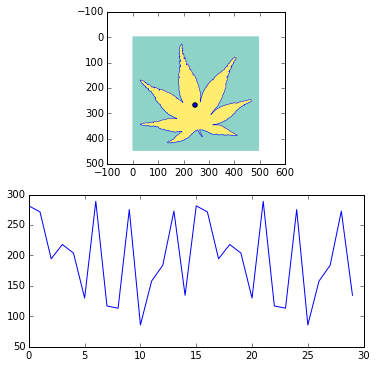

array([ 0.97414027,  0.93954366,  0.67314971,  0.75436403,  0.70595047,
        0.4499138 ,  1.        ,  0.40493816,  0.39242606,  0.95286954,
        0.2973514 ,  0.54644703,  0.63639823,  0.94430812,  0.46557002,
        0.97414027,  0.93954366,  0.67314971,  0.75436403,  0.70595047,
        0.4499138 ,  1.        ,  0.40493816,  0.39242606,  0.95286954,
        0.2973514 ,  0.54644703,  0.63639823,  0.94430812,  0.46557002])

In [5]:
leaf_img = [('Acer Palmatum', [27, 118, 203, 324, 960, 1041]), 
            ('Acer Pictum', [146, 311, 362, 810, 915, 949, 956]),
            ('Quercus Coccinea', [163, 189, 469, 510, 576, 605]),
            ('Quercus Rhysophylla', [375, 481, 876, 1120, 1163, 1323]),
            ('Salix Fragilis', [15, 620, 704, 847, 976, 1025])]
leaf_map = {'Acer Palmatum': 0, 'Acer Pictum': 1, 'Salix Fragilis': 2,
            'Quercus Rhysophylla': 3, 'Quercus Coccinea': 4}
data = []

for img in leaf_img:
    name, image_numbers = img[0], img[1]
    for number in image_numbers:
        data.append((convert_to_1d('./input/images/'+str(number)+'.jpg', plot=0), 
                     leaf_map[name]))
        
convert_to_1d('./input/images/27.jpg', plot=True)

## Step 4: creating some plots
For each of the five different leaves, we transform our dataset to a binary classification problem (one-vs-all) and find the most discriminative/characterizing shapelet

In [6]:
distances1 = convert_to_1d('./input/images/27.jpg', plot=0, norm=1)
distances1

array([ 0.97414027,  0.93954366,  0.67314971,  0.75436403,  0.70595047,
        0.4499138 ,  1.        ,  0.40493816,  0.39242606,  0.95286954,
        0.2973514 ,  0.54644703,  0.63639823,  0.94430812,  0.46557002,
        0.97414027,  0.93954366,  0.67314971,  0.75436403,  0.70595047,
        0.4499138 ,  1.        ,  0.40493816,  0.39242606,  0.95286954,
        0.2973514 ,  0.54644703,  0.63639823,  0.94430812,  0.46557002])

NameError: name 'shapelet_dict' is not defined

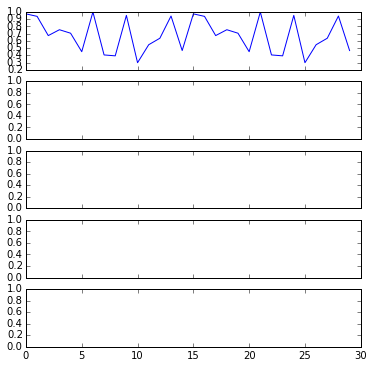

In [7]:
f, axarr = plt.subplots(5, sharex=True) # , sharex=True
axarr[0].plot(list(range(len(distances1))), distances1)
_dist, _idx = subsequence_dist(distances1, shapelet_dict[0])
axarr[0].plot(list(range(_idx, _idx+len(shapelet_dict[0]))), shapelet_dict[0], color='r')

In [10]:
type(data[0])

tuple

In [ ]:
shapelet_dict = extract_shapelets(data)

distances1 = convert_to_1d('./input/images/27.jpg', plot=0, norm=1)
distances2 = convert_to_1d('./input/images/146.jpg', plot=0, norm=1)
distances3 = convert_to_1d('./input/images/375.jpg', plot=0, norm=1)
distances4 = convert_to_1d('./input/images/15.jpg', plot=0, norm=1)
distances5 = convert_to_1d('./input/images/163.jpg', plot=0, norm=1)

f, axarr = plt.subplots(5, sharex=True) # , sharex=True

axarr[0].plot(list(range(len(distances1))), distances1)
_dist, _idx = subsequence_dist(distances1, shapelet_dict[0])
axarr[0].plot(list(range(_idx, _idx+len(shapelet_dict[0]))), shapelet_dict[0], color='r')

axarr[1].plot(distances2)
_dist, _idx = subsequence_dist(distances2, shapelet_dict[1])
axarr[1].plot(list(range(_idx, _idx+len(shapelet_dict[1]))), shapelet_dict[1], color='r')

axarr[2].plot(distances3)
_dist, _idx = subsequence_dist(distances3, shapelet_dict[2])
axarr[2].plot(list(range(_idx, _idx+len(shapelet_dict[2]))), shapelet_dict[2], color='r')

axarr[3].plot(distances4)
_dist, _idx = subsequence_dist(distances4, shapelet_dict[3])
axarr[3].plot(list(range(_idx, _idx+len(shapelet_dict[3]))), shapelet_dict[3], color='r')

axarr[4].plot(distances5)
_dist, _idx = subsequence_dist(distances5, shapelet_dict[4])
axarr[4].plot(list(range(_idx, _idx+len(shapelet_dict[4]))), shapelet_dict[4], color='r')

plt.show()

Except for the 4th time-serie, the shapelets seem to be quite characteristic for the leafs. Now we can use the minimal distance to each of these shapelets as features. Hope you enjoyed it.

**Feedback is always welcome!!**